<a href="https://colab.research.google.com/github/ssmehra7/random-test-ankit/blob/main/Regularizeshapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from sklearn.linear_model import LinearRegression

In [4]:
# read csv - as given in PS
def read_csv(csv_path):
    np_path_XYs=np.genfromtxt(csv_path,delimiter=',')
    path_XYs=[]
    for i in np.unique(np_path_XYs[:,0]):
        npXYs=np_path_XYs[np_path_XYs[:,0]==i][:,1:]
        XYs=[]
        for j in np.unique(npXYs[:,0]):
            XY=npXYs[npXYs[:,0]==j][:,1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# plot image - as given in PS
def plot_polylines(paths_XYs, save_path=None):
    fig, ax = plt.subplots(tight_layout=True, figsize=(4, 4))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2, label=f'Polyline {i}')
    ax.set_aspect("equal")
    ax.axis('off')

    if save_path:
        plt.savefig(save_path, format='jpg')

    plt.show()

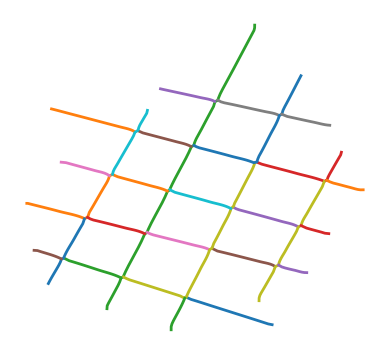

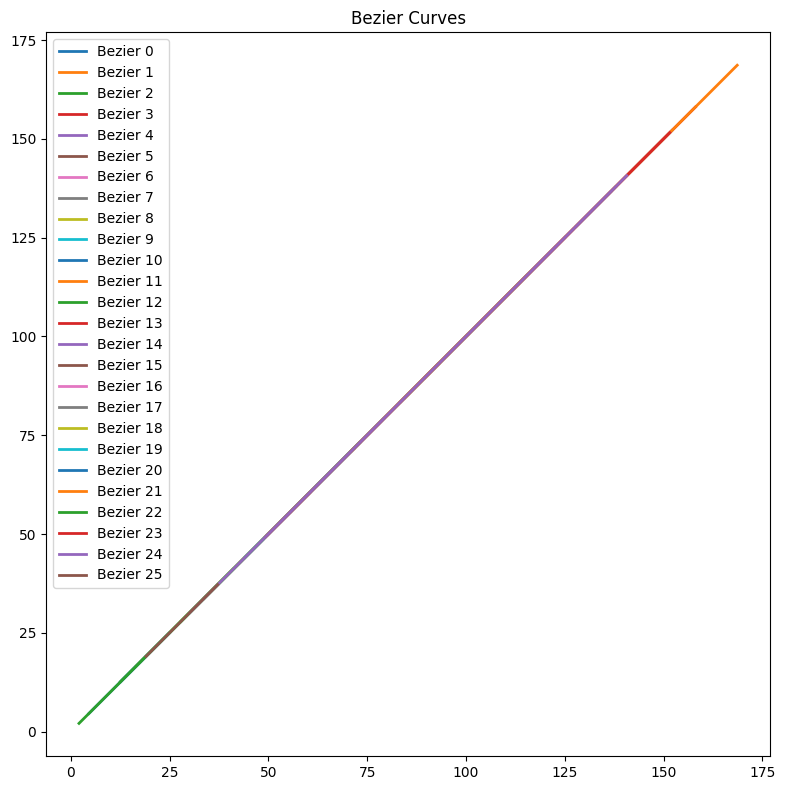

In [16]:
def adjust_control_points(points):
    # Ensure the first and last segments are straight
    if len(points) > 2:
        points[0] = 2 * points[1] - points[2]
        points[-1] = 2 * points[-2] -points[-3]
       # for i in range(1, len(points) - 1):
        #    points[i] = (points[i - 1] + points[i + 1]) / 2
    return points

from scipy.interpolate import splprep, splev

def generate_bezier_curve(points, s=0.8):
    points = adjust_control_points(points)
    tck, u = splprep([points[:, 0], points[:, 1]], s=s, k=3)
    unew = np.linspace(0, 1.0, 2000)
    out = splev(unew, tck)
    bezier_curve = np.vstack(out).T  # Stack and transpose to get shape (2000, 2)
    return bezier_curve

def plot_bezier_curves(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            bezier_curve = generate_bezier_curve(XY)
            ax.plot(bezier_curve[0], bezier_curve[1], linewidth=2, label=f'Bezier {i}')
    ax.set_aspect("equal")
    plt.legend()
    plt.title('Bezier Curves')
    plt.show()

# Example usage
csv_path2 = "/content/frag2.csv"
paths2 = read_csv(csv_path2)
plot_polylines(paths2)
plot_bezier_curves(paths2)

Mean Squared Error: 0.2121445177367694
Maximum Deviation: 1.075374612386753


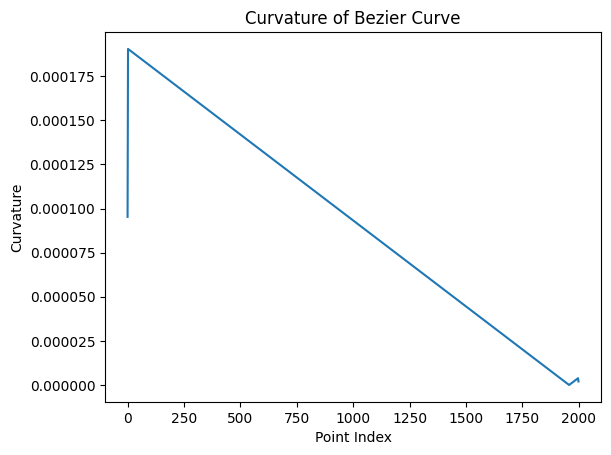

In [17]:
def evaluate_accuracy(original, bezier):
    original_interpolated = interpolate_points(original, len(bezier))
    mse = np.mean((original_interpolated - bezier)**2)
    max_deviation = np.max(np.abs(original_interpolated - bezier))
    return mse, max_deviation

def calculate_curvature(bezier):
    x, y = bezier[:, 0], bezier[:, 1]
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    return curvature

# Example usage
csv_path2 = "frag2.csv"
paths2 = read_csv(csv_path2)


# Evaluate accuracy for the first polyline and Bezier curve
original_points = paths2[0][0]
bezier_curve = generate_bezier_curve(original_points, s=0.8)
mse, max_deviation = evaluate_accuracy(original_points, bezier_curve)

print(f"Mean Squared Error: {mse}")
print(f"Maximum Deviation: {max_deviation}")

# Calculate and plot curvature
curvature = calculate_curvature(bezier_curve)
plt.plot(curvature)
plt.title('Curvature of Bezier Curve')
plt.xlabel('Point Index')
plt.ylabel('Curvature')
plt.show()

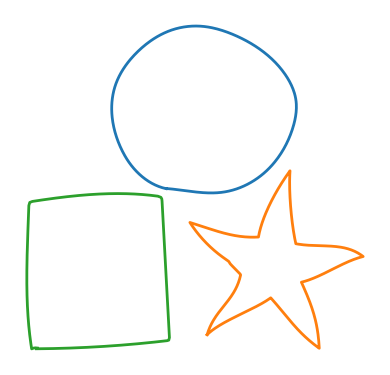

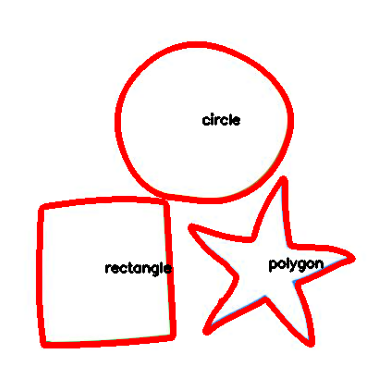

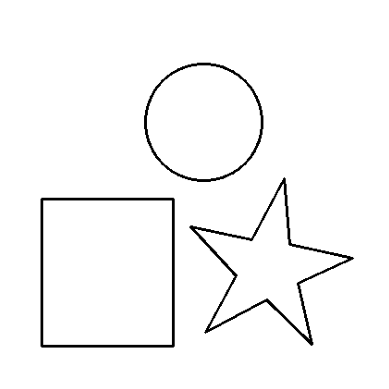

In [18]:
img = read_csv('/content/isolated.csv')
plot_polylines(img, 'isolated.jpg')
img = cv2.imread('isolated.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(gray, 50, 150)
kernel = np.ones((4, 4), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
contour, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def getShapeName(approx):
    if len(approx) == 2:
        shape_name = "line"
    elif len(approx) == 3:
        shape_name = "triangle"
    elif len(approx) == 4 or len(approx) == 5:
        # Check if the shape is a square or a rectangle
        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        if 0.95 <= aspect_ratio <= 1.05:
            shape_name = "square"
        else:
            shape_name = "rectangle"
    elif len(approx) > 12:
        shape_name = "circle"
    else:
        shape_name = "polygon"
    return shape_name

for i, cont in enumerate(contour):

    # Approximate the contour
    epsilon = 0.01 * cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, epsilon, True)

    # Draw the contour
    cv2.drawContours(img, [cont], 0, (255, 0, 0), 5)

    # Calculate moments for the center of the contour
    M = cv2.moments(cont)
    if M['m00'] != 0.0:
        x = int(M['m10'] / M['m00'])
        y = int(M['m01'] / M['m00'])

    # print(len(approx))

    shape_name = getShapeName(approx)
    # Put the text near the center of the shape
    cv2.putText(img, shape_name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)


def fit_line(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept

def draw_shape(image, shape_type, points):
    if shape_type == "line":
        pt1 = tuple(points[0][0])
        pt2 = tuple(points[1][0])
        cv2.line(image, pt1, pt2, 0, 2)

    elif shape_type == "rectangle":
        x, y, w, h = cv2.boundingRect(points)
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        cv2.rectangle(image, top_left, bottom_right, 0, 2)

    elif shape_type == "circle":
        (x, y), radius = cv2.minEnclosingCircle(points)
        center = (int(x), int(y))
        radius = int(radius)- 30
        cv2.circle(image, center, radius, 0, 2)

    elif shape_type == "triangle":
        cv2.drawContours(image, [points], 0, 0, 2)

    elif shape_type == "ellipse":
        ellipse = cv2.fitEllipse(points)
        cv2.ellipse(image, ellipse, 0, 2)

    elif shape_type == "polygon":
        cv2.polylines(image, [points], isClosed=True, color=0, thickness=2)

    else:
        raise ValueError("Unsupported shape_type")

def draw_fitted_line(image, slope, intercept, color):
    height, width = image.shape
    x1, y1 = 0, int(intercept)
    x2, y2 = width, int(slope * width + intercept)

    cv2.line(image, (x1, y1), (x2, y2), color, 2)


shape_image = np.ones_like(img)*255

for cont in contour:
    if i == 0:
        i = 1
        continue

    epsilon = 0.01 * cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, epsilon, True)
    # print(len(approx))
    shape_name = getShapeName(approx)
    if shape_name == 'line':
        points = np.vstack([point[0] for point in approx])
        slope, intercept = fit_line(points)
        draw_fitted_line(shape_image, slope, intercept, 255)
    elif shape_name == 'rectangle':
        draw_shape(shape_image, 'rectangle', approx)
    elif shape_name == 'circle':
        draw_shape(shape_image, 'circle', approx)
    elif shape_name == 'polygon':
        draw_shape(shape_image, 'polygon', approx)

# cv2.imshow('hello', img)
# cv2.waitKey(0)
# cv2.imshow('hello', shape_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(img)
plt.axis('off')
plt.show()

plt.imshow(shape_image)
plt.axis('off')
plt.show()


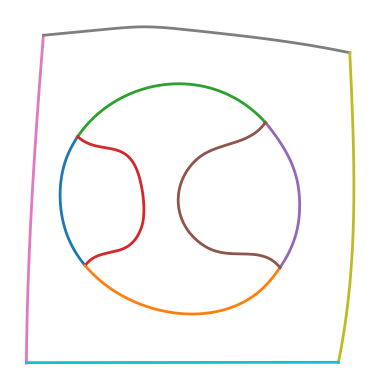

rectangle
rectangle
circle
polygon
polygon
circle


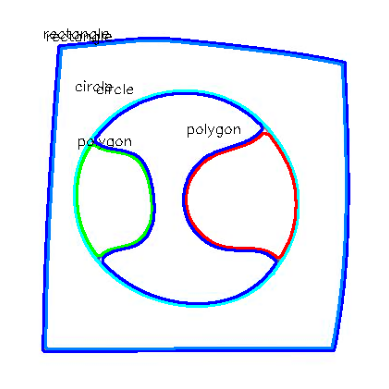

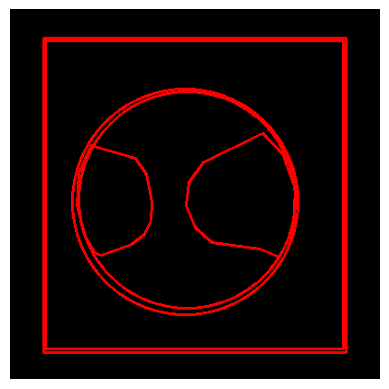

In [20]:
def fit_line(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept

def draw_shape(image, shape_type, points):
    if shape_type == "line":
        pt1 = tuple(points[0][0])
        pt2 = tuple(points[1][0])
        cv2.line(image, pt1, pt2, 255, 2)
    elif shape_type == "rectangle":
        # cv2.drawContours(image, [points], 0, 255, 2)
        x, y, w, h = cv2.boundingRect(points)
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        cv2.rectangle(image, top_left, bottom_right, 255, 2)
    elif shape_type == "circle":
        (x, y), radius = cv2.minEnclosingCircle(points)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(image, center, radius, 255, 2)
    elif shape_type == "polygon":
        cv2.polylines(image, [points], isClosed=True, color=255, thickness=2)

def draw_fitted_line(image, slope, intercept, color):
    height, width = image.shape
    x1, y1 = 0, int(intercept)
    x2, y2 = width, int(slope * width + intercept)

    cv2.line(image, (x1, y1), (x2, y2), color, 2)

img = read_csv('/content/frag0.csv')
plot_polylines(img, 'frag0.jpg')
img = cv2.imread('frag0.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(gray, 50, 150)
kernel = np.ones((4, 4), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
contour, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


def getShapeName(approx):
    if len(approx) == 2:
        shape_name = "line"
    elif len(approx) == 3:
        shape_name = "triangle"
    elif len(approx) == 4 or len(approx) == 5:
        shape_name = "rectangle"
    elif len(approx) > 12:
        shape_name = "circle"
    else:
        shape_name = "polygon"
    return shape_name

for i, cont in enumerate(contour):

    # Approximate the contour
    epsilon = 0.0095 * cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, epsilon, True)
    # print(len(approx))
    # Draw the contour
    colors = [(0, 0, 255), (0, 128, 255), (0, 255, 255), (0, 255, 0), (255, 0, 0)]
    cv2.drawContours(img, [cont], 0, colors[i%len(colors)], 2)

    # Calculate moments for the center of the contour
    M = cv2.moments(cont)
    if M['m00'] != 0.0:
        x = int(M['m10'] / M['m00'])
        y = int(M['m01'] / M['m00'])

    shape_name = getShapeName(approx)
    # Put the text near the center of the shape
    x, y, w, h = cv2.boundingRect(cont)
    cv2.putText(img, shape_name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

shape_image = np.zeros_like(img)



for cont in contour:
    if i == 0:
        i = 1
        continue

    epsilon = 0.0095 * cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, epsilon, True)
    shape_name = getShapeName(approx)
    print(shape_name)
    if shape_name == 'rectangle':
        draw_shape(shape_image, 'rectangle', approx)
    elif shape_name == 'circle':
        draw_shape(shape_image, 'circle', approx)
    elif shape_name == 'polygon':
        draw_shape(shape_image, 'polygon', approx)


plt.imshow(img)
plt.axis('off')
plt.show()

plt.imshow(shape_image)
plt.axis('off')
plt.show()